<h2>数据游戏Round1：预测5月15日招商银行关盘时的股价</h2>

导入相应的包并查看描述性统计以及数据的前后三行

In [1]:
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = ts.get_hist_data('600036')
print(data.shape)
data.describe()

(609, 13)


,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20
count,609.000000,609.000000,609.000000,609.000000,6.090000e+02,609.000000,609.000000,609.000000,609.000000,609.000000,6.090000e+02,6.090000e+02,609.000000
mean,26.346585,26.722939,26.386535,26.036437,5.002776e+05,0.029672,0.133432,26.336668,26.271023,26.132926,4.994673e+05,4.976905e+05,495505.406289
std,4.753645,4.870090,4.763828,4.653217,2.415818e+05,0.488736,1.750840,4.751646,4.734656,4.687829,1.848594e+05,1.656262e+05,150928.840617
min,17.530000,17.610000,17.490000,17.390000,1.009080e+05,-2.240000,-6.470000,17.634000,17.705000,17.869000,1.460539e+05,2.015588e+05,216380.080000
25%,22.980000,23.580000,23.030000,22.730000,3.276475e+05,-0.220000,-0.870000,22.700000,22.458000,22.131000,3.669532e+05,3.805330e+05,389129.980000
50%,27.650000,28.090000,27.660000,27.200000,4.493472e+05,0.010000,0.050000,27.632000,27.558000,27.521000,4.651292e+05,4.687378e+05,464215.570000
75%,29.450000,29.890000,29.500000,29.000000,6.258211e+05,0.290000,1.120000,29.350000,29.310000,29.174000,6.104938e+05,6.074965e+05,609243.550000
max,35.900000,36.480000,36.000000,35.650000,1.551975e+06,1.890000,6.950000,35.630000,35.428000,35.224000,1.238826e+06,1.024262e+06,890276.620000


这里我们只取几个关键特征

In [3]:
data1 = data[::-1][['open','high','low','ma5','close']]
data1.head(3), data1.tail(3)

(             open   high    low    ma5  close
 date                                         
 2016-11-09  18.00  18.08  17.77  17.89  17.89
 2016-11-10  17.95  18.11  17.94  17.94  17.99
 2016-11-11  17.95  18.08  17.93  17.97  18.03,
              open   high    low     ma5  close
 date                                          
 2019-05-08  33.30  33.58  33.00  34.106  33.13
 2019-05-09  33.00  33.25  32.02  33.524  32.42
 2019-05-10  32.86  33.80  32.86  33.330  33.48)

导入 sklearn 中相应的模块，这里我们用的是岭回归

In [4]:
from sklearn.linear_model import Ridge
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score

In [5]:
ridge = Ridge()

由于预测的是三天后的股价，那还需要 5月13、14号 的数据信息才能进行预测，因此先预测这两天的信息。

先设置一下训练集

In [6]:
y_train = data1['close'].values[1:]
X_train = data1.values[:-1]

我们用这组训练集做一下评估

In [7]:
def get_score(X_train, y_train):
    ridge_score = np.sqrt(-cross_val_score(ridge, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    return np.mean(ridge_score)

In [8]:
get_score(X_train, y_train)

0.4692812762015096

发现有0.469左右的错误率，这个错误率就很大了，不太合理，更何况还要预测其他特征值作为测试数据，那错误率就有点高了。因此，换一下训练集再做一下尝试。

In [9]:
data2 = data1[:]
y_train = data2.pop('close').values
X_train = data2.values

In [10]:
get_score(X_train, y_train)

0.18341941541272766

这次是把当天除了“close”以外的数据当作X_train，当天的“close”作为y_train，发现错误率少了很多。因此我们可以先预测一下三天的除“close”以外的数据，然后根据这些数据预测那三天当天的close值。

In [11]:
def get_model(s):
    y_train = data1[s].values[1:]
    X_train = data1.values[:-1]
    model = ridge.fit(X_train, y_train)
    return model

In [12]:
X_test = data1[-1:].values

In [13]:
def get_results(X_test):
    attrs = ['open', 'high', 'low', 'ma5']
    results = []
    for attr in attrs:
        result = get_model(attr).predict(X_test)
        results.append(result)
    return results

In [14]:
def get_close_model():
    y_train = data1['close']
    X_train = data1[['open', 'high', 'low', 'ma5']]
    close_model = ridge.fit(X_train, y_train)
    joblib.dump(ridge, 'close_model.m')

In [15]:
get_close_model()
close_model = joblib.load('close_model.m')

在预测之前呢，我们先拿训练集的后8组数据做一下测试，做个图看看，比较拟合的话就当作心理安慰，不太拟合的话...我也不知道怎么办了[Faceplam]

[array([34.56429711]), array([35.37160607]), array([34.32913151]), array([33.74837173]), array([33.58057848]), array([33.34347361]), array([32.52914614]), array([33.57743733])]


([<matplotlib.axis.XTick at 0xccf9030>,
 <a list of 8 Text xticklabel objects>)

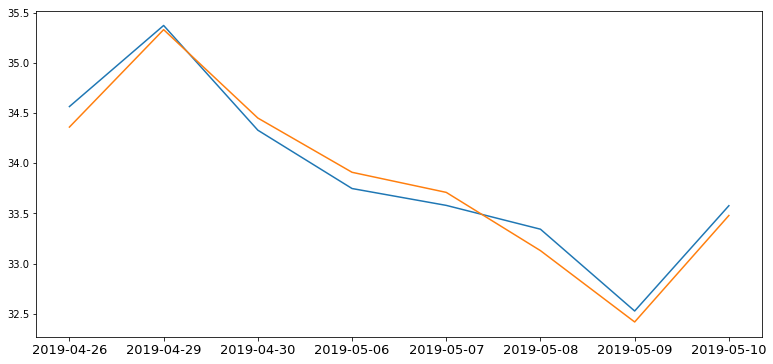

In [16]:
scores = []
for x in X_train[-8:]:
    score = close_model.predict(np.array(x).reshape(1, -1))
    scores.append(score)
print(scores)
x = np.arange(8)
fig, axes = plt.subplots(1, 1, figsize=(13, 6))
axes.plot(scores)
axes.plot(y_train[-8:])
plt.xticks(x, data1.index[-8:].values, size=13, rotation=0)

看到这样子我还是相对比较放心的，不过，这里面的除了“close”以外的特征值都是已知的...

In [17]:
for i in range(3):
    results = get_results(X_test)
    close = close_model.predict(np.array(results).reshape(1, -1))
    print(close)
    results.append(close)
    X_test = np.array(results).reshape(1, -1)
print("5月15日招商银行关盘时的股价为：" + str(round(close[0], 2)))

[33.46370029]
[33.4532047]
[33.43836721]
5月15日招商银行关盘时的股价为：33.44


虽然预测结果是这样子，但感觉应该还是差了很多啊。毕竟预测的每个特征值都会有偏差，多个特征的偏差累加起来就很多了，这让我有点害怕。不知道存不存在不预测其他特征值的方法，或者说直接预测5月15号的而不用先预测13、14号的方法。希望哪位大神看了能给我一些建议，指点迷津。这次数据游戏还不错，对于没项目可做的新手来说也算一次经历，而且也学到了一点东西。